✅ Workflow Plan:
* Step 1: Load and explore the dataset.
* Step 2: Preprocessing + add <start> and <end> tokens.
* Step 3: Tokenization (with <OOV> handling).
* Step 4: Padding and sequence preparation.
* Step 5: Model 1 — Seq2Seq encoder-decoder model setup.
* Step 6: Training + loss plots.
* Step 7: Model 2 — Transformer-style seq2seq setup.
* Step 8: Training + loss plots.
* Step 9: Inference testing on unseen data.

## Load & Explore Dataset

---



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt

# Path to your dataset (adjust if needed)
file_path = '/content/drive/MyDrive/MT_Data/english-arabic-dataset.txt'

# Load first 10,000 lines
with open(file_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()[:10000]

print(f"Total samples loaded: {len(lines)}")

Total samples loaded: 10000


In [3]:
# Separate English and Arabic sentences
eng_sentences = []
arb_sentences = []

for line in lines:
    try:
        eng, arb = line.strip().split('\t')
        eng_sentences.append(eng)
        arb_sentences.append(arb)
    except ValueError:
        continue
# Print 5 samples
for i in range(5):
    print(f"ENGLISH: {eng_sentences[i]}")
    print(f"ARABIC : {arb_sentences[i]}")
    print('---')

ENGLISH: Hi.
ARABIC : مرحبًا.
---
ENGLISH: Run!
ARABIC : اركض!
---
ENGLISH: Help!
ARABIC : النجدة!
---
ENGLISH: Jump!
ARABIC : اقفز!
---
ENGLISH: Stop!
ARABIC : قف!
---


In [4]:
# Sentence length analysis
eng_lengths = [len(sentence.split()) for sentence in eng_sentences]
arb_lengths = [len(sentence.split()) for sentence in arb_sentences]

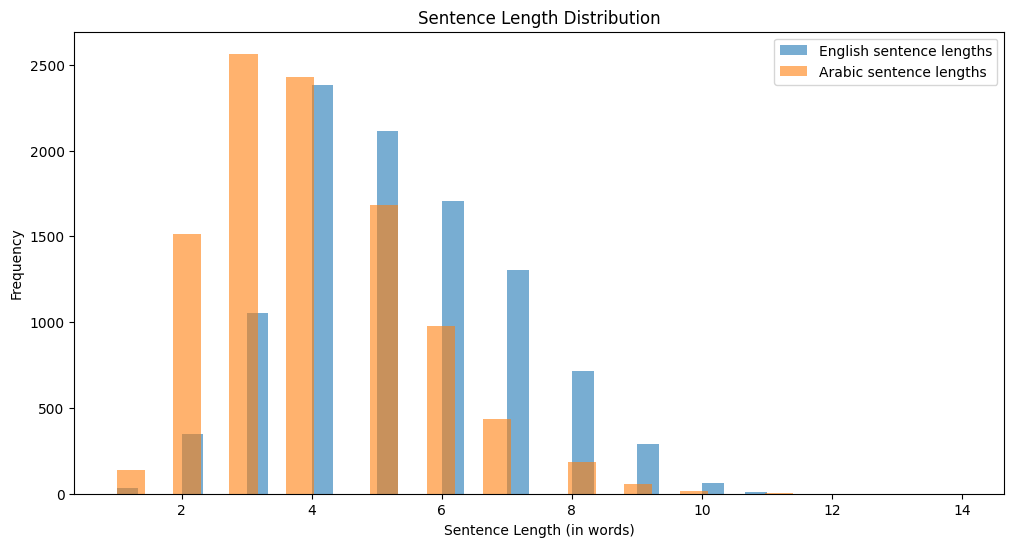

In [5]:
# Plot distributions
plt.figure(figsize=(12,6))
plt.hist(eng_lengths, bins=30, alpha=0.6, label='English sentence lengths')
plt.hist(arb_lengths, bins=30, alpha=0.6, label='Arabic sentence lengths')
plt.title("Sentence Length Distribution")
plt.xlabel("Sentence Length (in words)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [6]:
# Check max lengths
print(f"Max English sentence length: {max(eng_lengths)}")
print(f"Max Arabic sentence length: {max(arb_lengths)}")

Max English sentence length: 11
Max Arabic sentence length: 14


## Preprocessing + Adding <start>, <end> Tokens

---


*   Lowercase
*   Strip whitespace
*   Remove punctuation
*   Remove digits if any
*   Remove double spaces
*   Start and end tokens added only on Arabic sentences.


In [7]:
# Function to clean and add special tokens
import re

def clean_sentence(sentence):
    # Lowercase
    sentence = sentence.lower().strip()
    # Remove punctuation and digits
    sentence = re.sub(r"[^a-zA-Zء-ي\s]", "", sentence)  # keeps Arabic & English letters and spaces only
    # Remove extra spaces
    sentence = re.sub(r"\s+", " ", sentence)
    return sentence.strip()
def preprocess_arabic(sentence):
    sentence = clean_sentence(sentence)
    sentence = f"<start> {sentence} <end>"
    return sentence

def preprocess_english(sentence):
    sentence = clean_sentence(sentence)
    return sentence

# Apply cleaning
eng_sentences_cleaned = [preprocess_english(sent) for sent in eng_sentences]
arb_sentences_cleaned = [preprocess_arabic(sent) for sent in arb_sentences]

# Sanity check
for i in range(5):
    print(f"ENGLISH: {eng_sentences_cleaned[i]}")
    print(f"ARABIC : {arb_sentences_cleaned[i]}")
    print("---")

ENGLISH: hi
ARABIC : <start> مرحبا <end>
---
ENGLISH: run
ARABIC : <start> اركض <end>
---
ENGLISH: help
ARABIC : <start> النجدة <end>
---
ENGLISH: jump
ARABIC : <start> اقفز <end>
---
ENGLISH: stop
ARABIC : <start> قف <end>
---


## Tokenization with OOV handling and padding

---


In [49]:
# Vocab sizes from tokenizer (replace with yours):

#english_vocab_size = len(eng_tokenizer.word_index) + 1
#arabic_vocab_size = len(arb_tokenizer.word_index) + 1
english_vocab_size = 5000
arabic_vocab_size = 5000

max_eng_len = 11
max_ar_len = 15 # -1 to match input data

embedding_dim = 128
#lstm_units = 512
# Reduced LSTM units
#lstm_units = 384
lstm_units = 256
#lstm_units = 128

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# English tokenizer
eng_tokenizer = Tokenizer(num_words=english_vocab_size,oov_token="<OOV>")
eng_tokenizer.fit_on_texts(eng_sentences_cleaned)
eng_tensor = eng_tokenizer.texts_to_sequences(eng_sentences_cleaned)

# Arabic tokenizer
arb_tokenizer = Tokenizer(num_words=english_vocab_size,oov_token="<OOV>")
arb_tokenizer.fit_on_texts(arb_sentences_cleaned)
arb_tensor = arb_tokenizer.texts_to_sequences(arb_sentences_cleaned)

# Find max lengths
max_eng_length = max(len(seq) for seq in eng_tensor)
max_arb_length = max(len(seq) for seq in arb_tensor)

print(f"Max English sequence length: {max_eng_length}")
print(f"Max Arabic sequence length: {max_arb_length}")


Max English sequence length: 11
Max Arabic sequence length: 16


note : max length was 14 + 2 = 16

In [10]:
# Pad sequences
eng_tensor = pad_sequences(eng_tensor, maxlen=max_eng_len, padding='post')
arb_tensor = pad_sequences(arb_tensor, maxlen=max_ar_len, padding='post')


# Sanity check: print example
for i in range(3):
    print(f"English sequence: {eng_tensor[i]}")
    print(f"Arabic sequence: {arb_tensor[i]}")
    print("---")

print("Tokenization & padding step done bestie!")

English sequence: [874   0   0   0   0   0   0   0   0   0   0]
Arabic sequence: [  2 773   3   0   0   0   0   0   0   0   0   0   0   0   0]
---
English sequence: [292   0   0   0   0   0   0   0   0   0   0]
Arabic sequence: [   2 2354    3    0    0    0    0    0    0    0    0    0    0    0
    0]
---
English sequence: [55  0  0  0  0  0  0  0  0  0  0]
Arabic sequence: [  2 900   3   0   0   0   0   0   0   0   0   0   0   0   0]
---
Tokenization & padding step done bestie!


## Data Split - 75% train 25% test

In [11]:
from sklearn.model_selection import train_test_split

eng_train, eng_val, arb_train, arb_val = train_test_split(
    eng_tensor, arb_tensor, test_size=0.25, random_state=42 ,shuffle=True
)

print(f"Train English shape: {eng_train.shape}")
print(f"Val English shape: {eng_val.shape}")
print(f"Train Arabic shape: {arb_train.shape}")
print(f"Val Arabic shape: {arb_val.shape}")


Train English shape: (7500, 11)
Val English shape: (2500, 11)
Train Arabic shape: (7500, 15)
Val Arabic shape: (2500, 15)


## Seq2Seq with RNN-based encoder-decoder

* Static LR = 0.0005

* Add ReduceLROnPlateau with factor=0.5, patience=3

* Add EarlyStopping with patience=5

* Train for max 50 epochs -- early stop/ just an upper limit  

* Batch size 64


2ND APPROACH
   
*   Add Dropout layers (with rates between 0.3–0.5)

* Add L2 weight regularization

* Use LearningRateScheduler to fine-tune

* Reduce batch size from 64 to something like 32

3RD AOOROACH

* Recurrent dropout & L2 regularization
* Reduced LSTM units
* Gradient clipping in the optimizer
* Learning rate scheduler callback


4RTH APROACH
* Try reducing LSTM AGAIN

* Stronger L2 regularization

* Dropout after embeddings

* Gaussian noise for extra regularization

* Early stopping with more patience

In [12]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout, GaussianNoise, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau

In [13]:
# Custom loss function that ignores padding (zeros)
def masked_sparse_categorical_crossentropy(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, 0), dtype=tf.float32)
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    loss *= mask
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)


In [14]:
def scheduler(epoch, lr):
  if epoch < 8:
    return lr
  else:
    return lr * tf.math.exp(-0.1).numpy() # Convert Tensor to float using .numpy()
lr_scheduler = LearningRateScheduler(scheduler)

# Custom loss function that ignores padding (zeros)
def masked_sparse_categorical_crossentropy(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, 0), dtype=tf.float32)
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    loss *= mask
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

In [15]:
# Encoder

encoder_inputs = Input(shape=(None,))
encoder_embed = Embedding(english_vocab_size, embedding_dim, mask_zero=True)(encoder_inputs)
encoder_embed = Dropout(0.2)(encoder_embed)
encoder_embed = LayerNormalization()(encoder_embed)

encoder_lstm = LSTM(
    256,
    return_state=True,
    return_sequences=False,
    kernel_regularizer=regularizers.l2(1e-4),
    recurrent_regularizer=regularizers.l2(1e-4),
    recurrent_dropout=0.2
)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embed)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None,))
decoder_embed = Embedding(arabic_vocab_size, embedding_dim, mask_zero=True)(decoder_inputs)
decoder_embed = Dropout(0.2)(decoder_embed)
decoder_embed = LayerNormalization()(decoder_embed)

decoder_lstm = LSTM(
    256,
    return_sequences=True,
    return_state=True,
    kernel_regularizer=regularizers.l2(1e-4),
    recurrent_regularizer=regularizers.l2(1e-4),
    recurrent_dropout=0.2
)
decoder_outputs, _, _ = decoder_lstm(decoder_embed, initial_state=encoder_states)

decoder_dense = Dense(arabic_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [16]:
from tensorflow.keras.losses import sparse_categorical_crossentropy
def masked_sparse_categorical_crossentropy(y_true, y_pred):
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true, 0), dtype=tf.float32)
    loss *= mask
    return tf.reduce_sum(loss) / (tf.reduce_sum(mask) + 1e-6)


In [17]:
# Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Optimizer with gradient clipping
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)

model.compile(
    optimizer=optimizer,
    loss=masked_sparse_categorical_crossentropy,
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=2, min_lr=1e-6)

In [18]:
# Prepare data for decoder
train_arb_in = arb_train[:, :-1]
train_ar_out = arb_train[:, 1:]
val_ar_in = arb_val[:, :-1]
val_ar_out = arb_val[:, 1:]

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
lr_schedule = LearningRateScheduler(scheduler)

In [19]:
def create_sample_weights(y_true):
    return (y_true != 0).astype(float)

train_sample_weights = create_sample_weights(train_ar_out)
val_sample_weights = create_sample_weights(val_ar_out)

In [20]:
import numpy as np # Import numpy and assign it to the alias 'np'

print("encoder input shape:", eng_train.shape)
print("decoder input shape:", train_arb_in.shape)
print("decoder output shape:", train_ar_out.shape)
print("arabic vocab size:", arabic_vocab_size)
print("english vocab size:", english_vocab_size)
print("max_eng_len:", max_eng_len, "max_arb_len:", max_ar_len)
print("Unique y values:", np.unique(train_ar_out[:50]))

encoder input shape: (7500, 11)
decoder input shape: (7500, 14)
decoder output shape: (7500, 14)
arabic vocab size: 5000
english vocab size: 5000
max_eng_len: 11 max_arb_len: 15
Unique y values: [   0    1    3    4    5    6    7    8    9   10   11   12   13   14
   15   16   17   18   19   20   22   23   30   33   34   35   36   37
   38   40   43   51   62   63   66   68   72   73   75   78   79   80
   85   89   94  113  116  129  140  163  178  181  186  191  192  201
  212  217  218  239  243  266  276  305  308  314  349  370  396  412
  427  449  456  465  491  493  497  553  588  610  625  641  663  692
  720  735  740  743  788  837  841  846  852  874  888  902  926 1013
 1021 1092 1144 1170 1188 1208 1218 1246 1328 1339 1369 1402 1445 1515
 1522 1550 1567 1666 1717 1880 1932 1954 1959 1964 2096 2107 2212 2217
 2267 2345 2376 2505 2611 2639 2886 3431 3487 3570 3599 3767 3987 4277
 4428 4502 4503 4504 4606 4782 4968]


In [21]:
history = model.fit(
    [eng_train, train_arb_in],
    train_ar_out,
    sample_weight=train_sample_weights,
    validation_data=([eng_val, val_ar_in], val_ar_out, create_sample_weights(val_ar_out)),
    batch_size=64,
    epochs=50,
    callbacks=[lr_scheduler, reduce_lr, early_stop],
    verbose=2
)


Epoch 1/50
118/118 - 41s - 345ms/step - accuracy: 0.0807 - loss: 5.1297 - val_accuracy: 0.0915 - val_loss: 4.6483 - learning_rate: 1.0000e-03
Epoch 2/50
118/118 - 28s - 237ms/step - accuracy: 0.0997 - loss: 4.3516 - val_accuracy: 0.1078 - val_loss: 4.3556 - learning_rate: 1.0000e-03
Epoch 3/50
118/118 - 19s - 163ms/step - accuracy: 0.1185 - loss: 3.9015 - val_accuracy: 0.1183 - val_loss: 4.0943 - learning_rate: 1.0000e-03
Epoch 4/50
118/118 - 21s - 177ms/step - accuracy: 0.1357 - loss: 3.4435 - val_accuracy: 0.1284 - val_loss: 3.8759 - learning_rate: 1.0000e-03
Epoch 5/50
118/118 - 19s - 160ms/step - accuracy: 0.1522 - loss: 3.0058 - val_accuracy: 0.1349 - val_loss: 3.7272 - learning_rate: 1.0000e-03
Epoch 6/50
118/118 - 21s - 181ms/step - accuracy: 0.1695 - loss: 2.6056 - val_accuracy: 0.1421 - val_loss: 3.5841 - learning_rate: 1.0000e-03
Epoch 7/50
118/118 - 13s - 110ms/step - accuracy: 0.1873 - loss: 2.2443 - val_accuracy: 0.1467 - val_loss: 3.4988 - learning_rate: 1.0000e-03
Epoch 

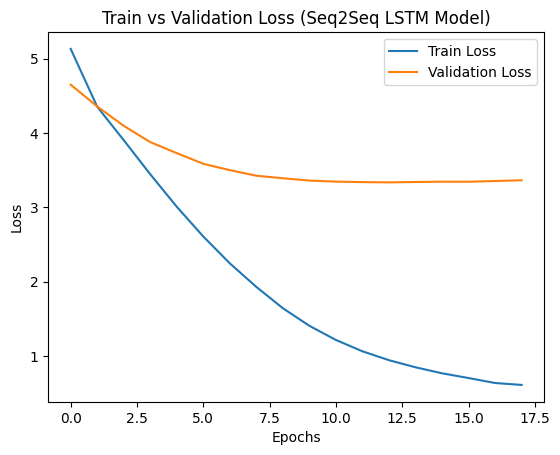

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Validation Loss (Seq2Seq LSTM Model)')
plt.show()

## Model 2 — Transformer-style Seq2Seq Setup

*    MultiHeadAttention, LayerNormalization, and Positional Embeddings.



Positional Encoding

In [23]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    sines = np.sin(angle_rads[:, 0::2])
    cosines = np.cos(angle_rads[:, 1::2])

    pos_encoding = np.concatenate([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [24]:
def transformer_encoder_block(embed_dim, num_heads, ff_dim, rate=0.1):
    inputs = layers.Input(shape=(None, embed_dim))
    attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
    attention = layers.Dropout(rate)(attention)
    attention = layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    ff = layers.Dense(ff_dim, activation="relu")(attention)
    ff = layers.Dense(embed_dim)(ff)
    ff = layers.Dropout(rate)(ff)

    outputs = layers.LayerNormalization(epsilon=1e-6)(attention + ff)
    return tf.keras.Model(inputs=inputs, outputs=outputs)


In [25]:
def transformer_decoder_block(embed_dim, num_heads, ff_dim, rate=0.1):
    enc_inputs = layers.Input(shape=(None, embed_dim))
    dec_inputs = layers.Input(shape=(None, embed_dim))

    attention1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(dec_inputs, dec_inputs)
    attention1 = layers.Dropout(rate)(attention1)
    attention1 = layers.LayerNormalization(epsilon=1e-6)(dec_inputs + attention1)

    attention2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(attention1, enc_inputs)
    attention2 = layers.Dropout(rate)(attention2)
    attention2 = layers.LayerNormalization(epsilon=1e-6)(attention1 + attention2)

    ff = layers.Dense(ff_dim, activation="relu")(attention2)
    ff = layers.Dense(embed_dim)(ff)
    ff = layers.Dropout(rate)(ff)

    outputs = layers.LayerNormalization(epsilon=1e-6)(attention2 + ff)
    return tf.keras.Model(inputs=[dec_inputs, enc_inputs], outputs=outputs)


In [26]:
def build_transformer_seq2seq(english_vocab_size, arabic_vocab_size, embed_dim, num_heads, ff_dim, max_eng_len, max_ar_len):
    encoder_inputs = layers.Input(shape=(max_eng_len,))
    decoder_inputs = layers.Input(shape=(max_ar_len,))

    # Encoder embeddings + positional
    enc_embed = layers.Embedding(english_vocab_size, embed_dim, mask_zero=True)(encoder_inputs)
    enc_pos = positional_encoding(max_eng_len, embed_dim)
    enc_embed = enc_embed + enc_pos
    enc_outputs = transformer_encoder_block(embed_dim, num_heads, ff_dim)(enc_embed)

    # Decoder embeddings + positional
    dec_embed = layers.Embedding(arabic_vocab_size, embed_dim, mask_zero=True)(decoder_inputs)
    dec_pos = positional_encoding(max_ar_len, embed_dim)
    dec_embed = dec_embed + dec_pos
    dec_outputs = transformer_decoder_block(embed_dim, num_heads, ff_dim)([dec_embed, enc_outputs])

    # Final Dense
    outputs = layers.Dense(arabic_vocab_size, activation='softmax')(dec_outputs)

    model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=outputs)
    return model


In [48]:
embed_dim = 128
num_heads = 4
ff_dim = 512


##  Training the Transformer Seq2Seq Model

* Optimizer = Adam
* Loss = Sparse categorical crossentropy (matching integer-encoded targets)
* Trimmed decoder input + shifted decoder target setup
* Plots for visualizing training

In [29]:
transformer_model = build_transformer_seq2seq(
    english_vocab_size=len(eng_tokenizer.word_index) + 1,
    arabic_vocab_size=len(arb_tokenizer.word_index) + 1,
    embed_dim=embed_dim,
    num_heads=num_heads,
    ff_dim=ff_dim,
    max_eng_len=max_eng_len,
    max_ar_len=max_ar_len
)

transformer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

transformer_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 11)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 15)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 11, 128)        │        458,112 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 15, 128)        │      1,122,944 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 11, 128)        │              0 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 15, 128)        │              0 │ embedding_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_1 (Functional) │ (None, 11, 128)        │        396,032 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_2 (Functional) │ (None, 15, 128)        │        660,096 │ add_3[0][0],           │
│                           │                        │                │ functional_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 15, 8773)       │      1,131,717 │ functional_2[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,768,901 (14.38 MB)

 Trainable params: 3,768,901 (14.38 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
decoder_target_data = decoder_inputs[:, 1:]  # shift by one
decoder_input_data_trimmed = decoder_inputs[:, :-1]  # input trimmed to align

In [50]:
history = model.fit(
    [eng_train, train_arb_in],
    train_ar_out,
    sample_weight=train_sample_weights,
    validation_data=([eng_val, val_ar_in], val_ar_out, val_sample_weights),
    epochs=20,
    batch_size=128,
    callbacks=[early_stop, reduce_lr, lr_scheduler]
)


Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.2997 - loss: 0.8134 - val_accuracy: 0.1613 - val_loss: 3.3354 - learning_rate: 1.8394e-04
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.3057 - loss: 0.7887 - val_accuracy: 0.1616 - val_loss: 3.3367 - learning_rate: 1.8394e-04
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - accuracy: 0.3066 - loss: 0.7736 - val_accuracy: 0.1620 - val_loss: 3.3381 - learning_rate: 1.8394e-04
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 0.3096 - loss: 0.7505 - val_accuracy: 0.1618 - val_loss: 3.3396 - learning_rate: 9.1970e-05
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.3101 - loss: 0.7409 - val_accuracy: 0.1618 - val_loss: 3.3412 - learning_rate: 9.1970e-05
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - accuracy: 0.3107 - loss: 0.7235 - val_accuracy: 0.1621 - val_loss: 3.3441 - learning_rate: 9.1970e-05


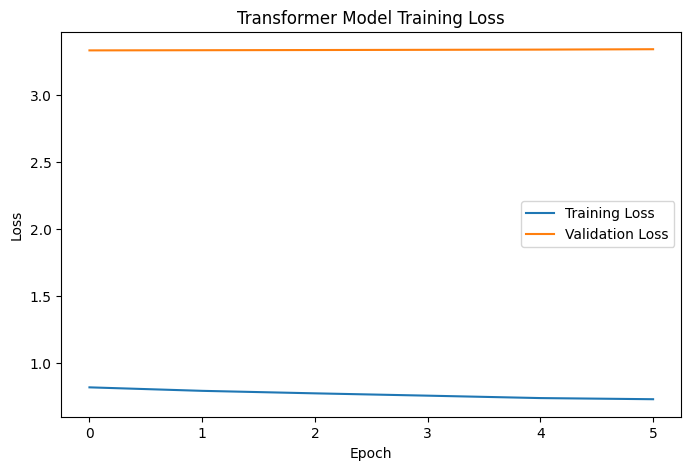

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Transformer Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Inference Testing on Unseen Data

In [80]:
import numpy as np

# Reverse-lookup dictionaries for decoding
reverse_arabic_word_index = {index: word for word, index in arb_tokenizer.word_index.items()}

# Get the necessary layers for inference
#encoder_model = Model(encoder_inputs, encoder_states)  # Create encoder inference model
# Modification: Instead of extracting layers, create a sub-model for inference
#encoder_model = Model(inputs=model.input[0], outputs=model.layers[5].output)  # encoder output
# FIX: Create sub-model with correct inputs and outputs
encoder_model = Model(inputs=model.input[0], outputs=[model.layers[5].output[0], model.layers[5].output[1]])  # encoder output (state_h, state_c)

decoder_embedding_layer = model.layers[3]  # Get decoder embedding layer from your main model
decoder_lstm = model.layers[6]  # Get decoder LSTM layer from your main model
decoder_dense = model.layers[7]  # Get decoder dense layer from your main model


def decode_sequence(input_seq):
    # Encode the input as state vectors using the encoder model (inference model)
    # Modification: Call the sub-model for inference
    #states_value = encoder_model(input_seq) # Get encoder states
    #states_value = encoder_model.predict(input_seq) # Get encoder states
    # FIX: Correctly get state_h and state_c from encoder
    states_value = encoder_model(input_seq)  # Get encoder states (state_h, state_c)

    # Generate empty target sequence of length 1 with just the <start> token
    target_seq = np.zeros((1, 1))
    # Set the first token to <start> if you defined it in your tokenizer, else just start from 0 or first prediction
    target_seq[0, 0] = arb_tokenizer.word_index.get('<start>', 1)

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        # Get the embedding for the target sequence using decoder_embedding_layer
        target_embed = decoder_embedding_layer(target_seq)

        # Pass the embedding and states to the decoder LSTM
        # Modification: remove 'initial_state'
        #output_tokens, h, c = decoder_lstm(target_embed, initial_state=states_value)
        # FIX: Provide correct initial states to decoder LSTM
        output_tokens, h, c = decoder_lstm(target_embed, initial_state=states_value)

        # Pass the output through the dense layer
        output_tokens = decoder_dense(output_tokens)

        # Sample the next token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = reverse_arabic_word_index.get(sampled_token_index, '')

        if sampled_word == '<end>' or sampled_word == '':
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_word

        # Update target sequence and states
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        # FIX: Update states_value with new states
        states_value = [h, c]

    return decoded_sentence.strip()

def encode_input_sentence(sentence):
    sentence = preprocess_english(sentence)
    sequence = eng_tokenizer.texts_to_sequences([sentence])
    sequence = pad_sequences(sequence, maxlen=max_eng_len, padding='post')
    return sequence

def predict_translation(sentence):
    input_seq = encode_input_sentence(sentence)
    translation = decode_sequence(input_seq)
    print(f"📝 English: {sentence}")
    print(f"🌸 Arabic: {translation}\n")

In [81]:
test_sentences = [
    "How are you today?",
    "I love learning new things.",
    "What time is the meeting?",
    "This project was challenging and fun!",
    "You are amazing."
]

for sent in test_sentences:
    predict_translation(sent)


KeyError: 'Exception encountered when calling Functional.call().\n\n\x1b[1m140143916202448\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=array([[ 45,  18,   3, 124,   0,   0,   0,   0,   0,   0,   0]],\n      dtype=int32)\n  • training=None\n  • mask=None'

In [82]:
test_sentence = "hello how are you"
input_seq = eng_tokenizer.texts_to_sequences([test_sentence])
input_seq = pad_sequences(input_seq, maxlen=max_eng_length, padding='post')


In [83]:
encoder_model = Model(encoder_inputs, encoder_states)


In [84]:
states_value = encoder_model.predict(input_seq)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
